In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_validate
import seaborn as sns
import sys
from sklearn.ensemble import GradientBoostingClassifier
import statistics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

# Defining train_model function

In [2]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    }
    
    model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(estimator=model, X=X, y=y, cv=kfold, scoring = scoring, n_jobs=-1)
    predictions = model.predict(X_test)
    return results, model, predictions, y_test

# Main code

In [3]:
# Read dataset
df = pd.read_csv(r'output_combined.csv')
# Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# Iteration 1

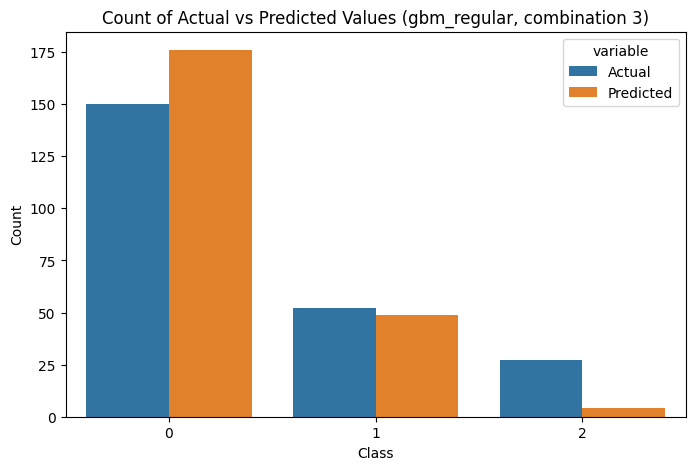

In [4]:
# Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4", "NH4", "SO2"]].copy()
df = df_selected
X = df.drop(columns=["day.type"])
y = df["day.type"] 
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('gbm_regular_combination_3.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (gbm_regular, combination 3)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('gbm_regular_combination_3.png', dpi=300)

# Iteration 2

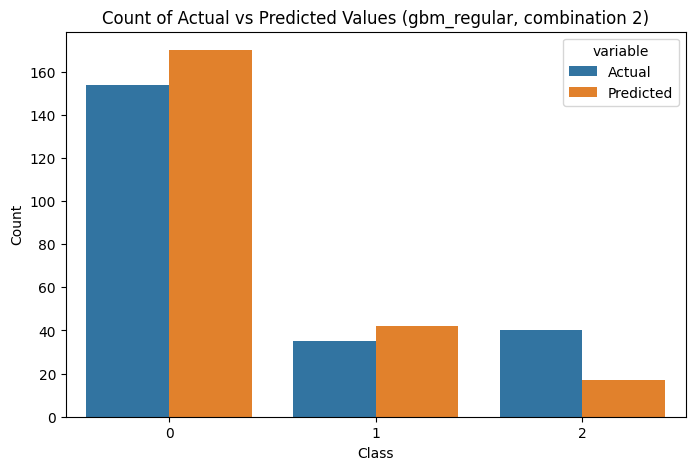

In [5]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('gbm_regular_combination_2.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (gbm_regular, combination 2)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('gbm_regular_combination_2.png', dpi=300)

# Iteration 3

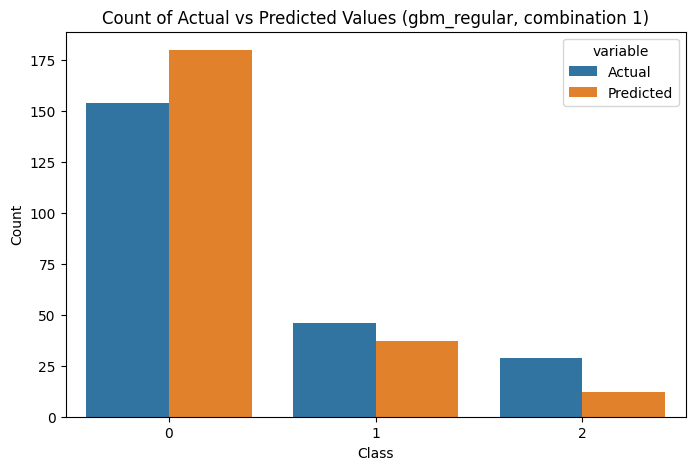

In [6]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('gbm_regular_combination_1.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (gbm_regular, combination 1)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('gbm_regular_combination_1.png', dpi=300) 